# Hyper-Parameter Tuning

This Jupyter Notebook uses hyper-parameter tuning to optimize model performance, with Logistic Regression, Decision Tree, Random Forest, Support Vector Machine, and K-Nearest Neighbor models used for classification and performance evaluated using cross-validation scoring.  Parameters were tuned using a GridSearch estimator.

## Approach
* Evaluations of classification performed were performed using 2 sample datasets:
    * sklearn's Iris sample dataset, consisting of 150 sample data points for 3 varieties of iris flowers
    * voice dataset, containing 3168 sample data points of male and female speakers

* Hyper-parameter tuning was performed using a GridSearch estimator for each classification model:
    
* Parameters providing the best scores and associated scores were plotted
    
## Results
* Refer to the Figures and Table of results provided below
* Hyperparameter tuning provided by sklearn GridSearchCV provided a convenient method of evaluating many classification model parameter sets in an efficient way.  The blue dots represent the optimal parameter sets selected for each Dataset/Classification Model, and the grey dots represent suboptimal parameter sets.
* For the Iris dataset, the Support Vector Machine SVC model provided the  combination of best score of 0.964 and Mean Fit Time of 0.200 ms, with Random Forest and Decision Tree classifiers providing close performance.
* For the Voice dataset, the SVC classifer also had the hightest Best Score at 0.980, which was slightly above the performance of the Random Forest classifier.  With SVC, the fit time was singificantly higher for the Voice dataset (40.6 ms) than for the Iris dataset (0.2 ms), which is expected given the larger number of features associated with the Voice dataset (20) vs. the Iris dataset (4)
* It's interesting to note that the K-Nearest Neighbors classifier, while performing lower amongst these models, operated with fast Mean Fit Time (3.2 ms) for Voice, which might make using KNN a good choice vs. other more calculation-intensive options in cases where lower fit time is more important than optimum accuracy.

| Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) - All Datasets/Classifiers | Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) including Suboptimal Results - All Datasets/Classifiers |
| :----------: | :----------: |
| ![Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) - All Datasets/Classifiers is Loading...](docs/8-Figure-Hyper_Parameter_Tuning-Combined.png "8-Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) - All Datasets/Classifiers") | ![Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) including Suboptimal Results - All Datasets/Classifiers is Loading...](docs/8-Figure-Hyper_Parameter_Tuning-Including_Suboptimal-Combined.png "8-Figure: Tuned Classifier Performance: Best Score vs. Mean Fit Time (ms) including Suboptimal Results - All Datasets/Classifiers") |

| Figure: Tuned Classifier Performance: Best Score vs. F1 Score - All Datasets/Classifiers | Figure: Tuned Classifier Performance: Precision vs. Recall - All Datasets/Classifiers |
| :----------: | :----------: |
| ![Figure: Tuned Classifier Performance: Best Score vs. F1 Score - All Datasets/Classifiers is Loading...](docs/8-Figure-Hyper_Parameter_Tuning-BestScore_vs_F1-Combined.png "8-Figure: uned Classifier Performance: Best Score vs. F1 Score - All Datasets/Classifiers") | ![Figure: Tuned Classifier Performance: Precision vs. Recall - All Datasets/Classifiers is Loading...](docs/8-Figure-Hyper_Parameter_Tuning-Precision_vs_Recall-Combined.png "8-Figure: Tuned Classifier Performance: Precision vs. Recall - All Datasets/Classifiers") |

| Figure: Tuned Classifier Performance - Subplots |
| :----------: |
| ![Figure: Tuned Classifier Performance - Subplots is Loading...](docs/8-Figure-Hyper_Parameter_Tuning-Subplots.png "8-Figure: Tuned Classifier Performance - Subplots") |

| Table: Tuned Classifier Performance |
| :----------: |
| ![Table: Tuned Classifier Performance is Loading...](docs/8-Table-Hyper_Parameter_Tuning.png "8-Table: Tuned Classifier Performance") |

# Dependencies

In [1]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # Support 3D graphing

import numpy as np
import pandas as pd
from pandas.plotting import table
import math

from pprint import pprint

# Visualization
import graphviz
import pydotplus
from IPython.display import Image

# Machine Learning - Linear Models - Regression
from sklearn.linear_model import LinearRegression  # TBD
from sklearn.linear_model import Lasso             # TBD
from sklearn.linear_model import Ridge             # TBD
from sklearn.linear_model import ElasticNet        # TBD

# Machine Learning - Linear Models - Classification
from sklearn.linear_model import LogisticRegression   # Logistic Regression Classifier

# Machine Learning - Decision Trees and Random Forests - Classification
from sklearn import tree                             # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier

# Machine Learning - Support Vector Machines - Classification
from sklearn import svm                              # Support Vector Machine Classifier


# Machine Leardning - K-Nearest Neighbors - Classification
from sklearn.neighbors import KNeighborsClassifier   # K-Nearest Neighbors (KNN)

# Machine Learning - GridSearch for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV


# Machine Learning - Data Preparation and Pre-Processing
from sklearn.model_selection import train_test_split # Split data into training and testing samples
from sklearn.model_selection import cross_val_score  # Score a model using k-fold or other cross validation

from sklearn.preprocessing import OneHotEncoder   # Convert categorical integer features (X) to One-Hot encoded values
from sklearn.preprocessing import LabelEncoder    # Convert categorical labeled values to categorical integer values
from sklearn.preprocessing import LabelBinarizer  # Convert categorical labeled values to Binary encoded values

from sklearn.preprocessing import StandardScaler  # Scale numerical features to standard normal distribution
from sklearn.preprocessing import MinMaxScaler    # Scale numerical values based upon mix/max values

# Machine Learning - Quantify Model Performance
from sklearn.metrics import mean_squared_error    # Mean Squared Error (MSE) metric
from sklearn.metrics import r2_score              # R-squared (Coefficient of Determination) metric
from sklearn.metrics import confusion_matrix      # Generate a confusion matrix (actual vs. predicted counts)
from sklearn.metrics import classification_report # Calculate metrics for prediction performance
from sklearn.metrics import precision_score       # Calculate the precision: Tp / (Tp + Fp) => Ability to avoid false negatives
from sklearn.metrics import recall_score          # Calculate the recall: Tp / (Tp + Fn) => Ability to find all positive samples
from sklearn.metrics import f1_score              # Calculate the F1 score: 2*(precision*recall)/(precision+recall)

# Machine Learning - Dataset Generation
from sklearn.datasets import make_regression     # Generate linear data
from sklearn.datasets import make_s_curve        # Generate nonlinear data
from sklearn.datasets import make_blobs          # Generate blobs for classification
from sklearn.datasets import make_circles        # Generate circles for classification
from sklearn.datasets import load_iris           # Sample multi-class dataset for classification

# Hyper-Parameter Tuning

### Function to Fit Model, Evaluate Performance, and Tune

In [2]:
# Function to tune and evaluate a model, calculate predictions, and create a residuals chart
def tune_eval_classifier(a_ds_name, a_model, a_param_grid):
    # Get the model information
    m_info = str(a_model)
    
    # Get the name of this model
    m_name = m_info.split("(",1)[0]    
    
    # Get the GridSearch estimator using the specified classifier model
    # and parameter grid and score the results uging using 5-fold cross-validation
    tuning_classifier = GridSearchCV( a_model, param_grid=a_param_grid, cv=5, return_train_score=False, n_jobs=-1)
    
    # Find the parameters providing the best performance 
    # Note: Not using scaled y in this case
    tuning_classifier.fit(X_train_scaled, y_train.reshape(-1) )
    
    # Calculate the Precision Score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
    m_precision_score = precision_score( y_test, tuning_classifier.predict(X_test_scaled), average='micro' )

    # Calculate the Recall Score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
    m_recall_score = recall_score( y_test, tuning_classifier.predict(X_test_scaled), average='micro' )

    # Calculate the F1 Score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
    # Note: Could also have just used f1 = 2*(precision_score * recall_score) / (precision_score + recall_score)
    m_f1_score = f1_score( y_test, tuning_classifier.predict(X_test_scaled), average='micro' )

    # Print a separator
    print("*"*80)
    
    print(f"\nModel: {m_name}, Best Score: {tuning_classifier.best_score_}")
    print(f"Best Parameters: {tuning_classifier.best_params_}")
    print(f"F1: {m_f1_score}, Precision: {m_precision_score}, Recall: {m_recall_score}")
    
    # Return the results
    a_result = {
        'Dataset': a_ds_name,
        'Classifier': m_name,
        'Best Score': tuning_classifier.best_score_,
        'Best Parameters': tuning_classifier.best_params_,
        'F1': m_f1_score,
        'Precision': m_precision_score,
        'Recall': m_recall_score,
        'Mean Fit Time (ms)': 1000.0*tuning_classifier.cv_results_['mean_fit_time'][ tuning_classifier.best_index_ ],
        'Std Dev Fit Time (ms)': 1000.0*tuning_classifier.cv_results_['std_fit_time'][ tuning_classifier.best_index_ ],

        'Best Index': tuning_classifier.best_index_,
        'CV Results': tuning_classifier.cv_results_,
    }
    
    return a_result


# Prepare to gather summary results

In [3]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# Iris Dataset

In [4]:
# Import the Iris sample dataset as a dictionary
iris = load_iris()

print( f"Iris {iris.keys()}" )
print( f"Feature Names: {iris.feature_names}" )
print( f"Target Names: {iris.target_names}" )

Iris dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


In [5]:
# Assign data and target variables
X = iris.data
y = iris.target
print( X.shape, y.shape )

(150, 4) (150,)


In [6]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [7]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train.shape, y_test.shape)

(112, 1) (38, 1)


In [8]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [9]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Evaluate classifiers - Iris Dataset

In [10]:
%%timeit -n1 -r1 -o  # Time the overall time required to evaluate all classifiers

# Create a list of classifers and associated parameter grid for hyperparameter tuning
classifier_dict = [
    {
        # LogisticRegression
        'cls': LogisticRegression(),
        'cls_param_grid': {'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
                           'max_iter': [ 100, 500, 1000, 5000, 10000 ],
                           'C': [1.0, 2.0, 5.0, 10.0, 20.0 ]}
    },
    {
        # Decision Tree
        'cls': tree.DecisionTreeClassifier(),
        'cls_param_grid': {'max_depth': [ None, 16, 8, 4, 2, 1 ],
                         'max_features': [ None, "sqrt", "log2" ]}
    },
    {
        # Random Forest
        'cls': RandomForestClassifier(),
        'cls_param_grid': {'max_depth': [ None, 16, 8, 4, 2, 1 ],
                         'max_features': [ None, "sqrt", "log2" ]}
    },
    {
        # Support Vector Machine
        'cls': svm.SVC(),
        'cls_param_grid': {'kernel': [ "linear", "poly", "rbf", "sigmoid" ],
                         'max_iter': [ 100, 500, 1000, 5000, 10000 ],
                         'C': [1.0, 2.0, 5.0, 10.0, 20.0 ]}
    },

    {
        # K-Nearest Neighbors
        'cls': KNeighborsClassifier(),
        'cls_param_grid': { 'n_neighbors': [ 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21 ],
                            'algorithm': [ 'auto', 'ball_tree', 'kd_tree', 'brute' ]
                          }
    }
]


# Evaluate each classifier with hyperparameter tuning
for c in classifier_dict:
    # Evaluate the classifer performance, create a plot    
    model_result_item = tune_eval_classifier('Iris', c['cls'], c['cls_param_grid'])

    # Add results for this dataset and model
    model_results.append( model_result_item )


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


********************************************************************************

Model: LogisticRegression, Best Score: 0.9196428571428571
Best Parameters: {'C': 2.0, 'max_iter': 100, 'solver': 'newton-cg'}
F1: 0.9473684210526315, Precision: 0.9473684210526315, Recall: 0.9473684210526315
********************************************************************************

Model: DecisionTreeClassifier, Best Score: 0.9464285714285714
Best Parameters: {'max_depth': None, 'max_features': 'log2'}
F1: 0.9473684210526315, Precision: 0.9473684210526315, Recall: 0.9473684210526315


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************

Model: RandomForestClassifier, Best Score: 0.9553571428571429
Best Parameters: {'max_depth': 1, 'max_features': None}
F1: 0.9736842105263158, Precision: 0.9736842105263158, Recall: 0.9736842105263158
********************************************************************************

Model: SVC, Best Score: 0.9642857142857143
Best Parameters: {'C': 2.0, 'kernel': 'linear', 'max_iter': 100}
F1: 0.9736842105263158, Precision: 0.9736842105263158, Recall: 0.9736842105263158
********************************************************************************

Model: KNeighborsClassifier, Best Score: 0.9464285714285714
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5}
F1: 0.9736842105263158, Precision: 0.9736842105263158, Recall: 0.9736842105263158
4.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<TimeitResult : 4.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [11]:

pd.DataFrame(model_results)

,Dataset,Classifier,Best Score,Best Parameters,F1,Precision,Recall,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Index,CV Results
0,Iris,LogisticRegression,0.919643,"{'C': 2.0, 'max_iter': 100, 'solver': 'newton-...",0.947368,0.947368,0.947368,17.999935,0.632636,26,"{'mean_fit_time': [0.0112060546875, 0.01900496..."
1,Iris,DecisionTreeClassifier,0.946429,"{'max_depth': None, 'max_features': 'log2'}",0.947368,0.947368,0.947368,0.400114,0.490038,2,"{'mean_fit_time': [0.0010003089904785157, 0.00..."
2,Iris,RandomForestClassifier,0.955357,"{'max_depth': 1, 'max_features': None}",0.973684,0.973684,0.973684,18.800640,2.482848,15,"{'mean_fit_time': [0.021199560165405272, 0.026..."
3,Iris,SVC,0.964286,"{'C': 2.0, 'kernel': 'linear', 'max_iter': 100}",0.973684,0.973684,0.973684,0.200272,0.400543,20,"{'mean_fit_time': [0.0009999275207519531, 0.00..."
4,Iris,KNeighborsClassifier,0.946429,"{'algorithm': 'auto', 'n_neighbors': 5}",0.973684,0.973684,0.973684,1.000071,0.010132,2,"{'mean_fit_time': [0.000800180435180664, 0.000..."


# Voice Dataset

In [12]:
## Import Data and Pre-Process: Voice Dataset
voice = pd.read_csv('resources/voice.csv')
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [13]:
# Check datatypes to ensure numerical values are floats vs. objects -- CONFIRMED
# voice.dtypes

In [14]:
# Assign X (data) and y (target)
X = voice.drop("label", axis=1)
y = voice["label"]
print(X.shape, y.shape)

(3168, 20) (3168,)


In [15]:
# Encode the output strings using a Categorical Binarizer
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [16]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [17]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
# print(y_train.shape, y_test.shape)

In [18]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [19]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Evaluate classifiers - Voice Dataset

In [20]:
%%timeit -n1 -r1 -o  # Time the overall time required to evaluate all classifiers

# Create a list of classifers and associated parameter grid for hyperparameter tuning
classifier_dict = [
    {
        # LogisticRegression
        'cls': LogisticRegression(),
        'cls_param_grid': {'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
                           'max_iter': [ 100, 500, 1000, 5000, 10000 ],
                           'C': [1.0, 2.0, 5.0, 10.0, 20.0 ]}
    },
    {
        # Decision Tree
        'cls': tree.DecisionTreeClassifier(),
        'cls_param_grid': {'max_depth': [ None, 16, 8, 4, 2, 1 ],
                         'max_features': [ None, "sqrt", "log2" ]}
    },
    {
        # Random Forest
        'cls': RandomForestClassifier(),
        'cls_param_grid': {'max_depth': [ None, 16, 8, 4, 2, 1 ],
                         'max_features': [ None, "sqrt", "log2" ]}
    },
    {
        # Support Vector Machine
        'cls': svm.SVC(),
        'cls_param_grid': {'kernel': [ "linear", "poly", "rbf", "sigmoid" ],
                         'max_iter': [ 100, 500, 1000, 5000, 10000 ],
                         'C': [1.0, 2.0, 5.0, 10.0, 20.0 ]}
    },

    {
        # K-Nearest Neighbors
        'cls': KNeighborsClassifier(),
        'cls_param_grid': { 'n_neighbors': [ 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21 ],
                            'algorithm': [ 'auto', 'ball_tree', 'kd_tree', 'brute' ]
                          }
    }
]


# Evaluate each classifier with hyperparameter tuning
for c in classifier_dict:
    # Evaluate the classifer performance, create a plot    
    model_result_item = tune_eval_classifier('Voice', c['cls'], c['cls_param_grid'])

    # Add results for this dataset and model
    model_results.append( model_result_item )


********************************************************************************

Model: LogisticRegression, Best Score: 0.9705387205387206
Best Parameters: {'C': 1.0, 'max_iter': 100, 'solver': 'newton-cg'}
F1: 0.9772727272727273, Precision: 0.9772727272727273, Recall: 0.9772727272727273
********************************************************************************

Model: DecisionTreeClassifier, Best Score: 0.9650673400673401
Best Parameters: {'max_depth': 4, 'max_features': None}
F1: 0.9734848484848485, Precision: 0.9734848484848485, Recall: 0.9734848484848485


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************

Model: RandomForestClassifier, Best Score: 0.9776936026936027
Best Parameters: {'max_depth': 8, 'max_features': 'sqrt'}
F1: 0.9797979797979798, Precision: 0.9797979797979798, Recall: 0.9797979797979798


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


********************************************************************************

Model: SVC, Best Score: 0.9797979797979798
Best Parameters: {'C': 2.0, 'kernel': 'rbf', 'max_iter': 500}
F1: 0.9873737373737373, Precision: 0.9873737373737373, Recall: 0.9873737373737373
********************************************************************************

Model: KNeighborsClassifier, Best Score: 0.9675925925925926
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 1}
F1: 0.9823232323232324, Precision: 0.9823232323232324, Recall: 0.9823232323232324
18.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 18.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [21]:
pd.DataFrame(model_results)

,Dataset,Classifier,Best Score,Best Parameters,F1,Precision,Recall,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Index,CV Results
0,Iris,LogisticRegression,0.919643,"{'C': 2.0, 'max_iter': 100, 'solver': 'newton-...",0.947368,0.947368,0.947368,17.999935,0.632636,26,"{'mean_fit_time': [0.0112060546875, 0.01900496..."
1,Iris,DecisionTreeClassifier,0.946429,"{'max_depth': None, 'max_features': 'log2'}",0.947368,0.947368,0.947368,0.400114,0.490038,2,"{'mean_fit_time': [0.0010003089904785157, 0.00..."
2,Iris,RandomForestClassifier,0.955357,"{'max_depth': 1, 'max_features': None}",0.973684,0.973684,0.973684,18.800640,2.482848,15,"{'mean_fit_time': [0.021199560165405272, 0.026..."
3,Iris,SVC,0.964286,"{'C': 2.0, 'kernel': 'linear', 'max_iter': 100}",0.973684,0.973684,0.973684,0.200272,0.400543,20,"{'mean_fit_time': [0.0009999275207519531, 0.00..."
4,Iris,KNeighborsClassifier,0.946429,"{'algorithm': 'auto', 'n_neighbors': 5}",0.973684,0.973684,0.973684,1.000071,0.010132,2,"{'mean_fit_time': [0.000800180435180664, 0.000..."
5,Voice,LogisticRegression,0.970539,"{'C': 1.0, 'max_iter': 100, 'solver': 'newton-...",0.977273,0.977273,0.977273,78.004026,4.939072,1,"{'mean_fit_time': [0.008799409866333008, 0.078..."
6,Voice,DecisionTreeClassifier,0.965067,"{'max_depth': 4, 'max_features': None}",0.973485,0.973485,0.973485,19.804573,0.749373,9,"{'mean_fit_time': [0.03040037155151367, 0.0083..."
7,Voice,RandomForestClassifier,0.977694,"{'max_depth': 8, 'max_features': 'sqrt'}",0.979798,0.979798,0.979798,66.199589,9.764994,7,"{'mean_fit_time': [0.2124000072479248, 0.06420..."
8,Voice,SVC,0.979798,"{'C': 2.0, 'kernel': 'rbf', 'max_iter': 500}",0.987374,0.987374,0.987374,40.601683,1.354254,31,"{'mean_fit_time': [0.010400342941284179, 0.031..."
9,Voice,KNeighborsClassifier,0.967593,"{'algorithm': 'auto', 'n_neighbors': 1}",0.982323,0.982323,0.982323,3.199911,0.400616,0,"{'mean_fit_time': [0.003199911117553711, 0.003..."


## Overall Results

## Summary - Iris and Voice Datasets

In [22]:
# Prepare a dataframe of the results
summary_df = pd.DataFrame( model_results,
                         columns = [ 'Dataset', 'Classifier',
                                    'Best Score', "F1", 'Precision', 'Recall',
                                    'Mean Fit Time (ms)', 'Std Dev Fit Time (ms)',
                                    'Best Parameters',
                                    'Best Index', 'CV Results' ])

summary_df

,Dataset,Classifier,Best Score,F1,Precision,Recall,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Parameters,Best Index,CV Results
0,Iris,LogisticRegression,0.919643,0.947368,0.947368,0.947368,17.999935,0.632636,"{'C': 2.0, 'max_iter': 100, 'solver': 'newton-...",26,"{'mean_fit_time': [0.0112060546875, 0.01900496..."
1,Iris,DecisionTreeClassifier,0.946429,0.947368,0.947368,0.947368,0.400114,0.490038,"{'max_depth': None, 'max_features': 'log2'}",2,"{'mean_fit_time': [0.0010003089904785157, 0.00..."
2,Iris,RandomForestClassifier,0.955357,0.973684,0.973684,0.973684,18.800640,2.482848,"{'max_depth': 1, 'max_features': None}",15,"{'mean_fit_time': [0.021199560165405272, 0.026..."
3,Iris,SVC,0.964286,0.973684,0.973684,0.973684,0.200272,0.400543,"{'C': 2.0, 'kernel': 'linear', 'max_iter': 100}",20,"{'mean_fit_time': [0.0009999275207519531, 0.00..."
4,Iris,KNeighborsClassifier,0.946429,0.973684,0.973684,0.973684,1.000071,0.010132,"{'algorithm': 'auto', 'n_neighbors': 5}",2,"{'mean_fit_time': [0.000800180435180664, 0.000..."
5,Voice,LogisticRegression,0.970539,0.977273,0.977273,0.977273,78.004026,4.939072,"{'C': 1.0, 'max_iter': 100, 'solver': 'newton-...",1,"{'mean_fit_time': [0.008799409866333008, 0.078..."
6,Voice,DecisionTreeClassifier,0.965067,0.973485,0.973485,0.973485,19.804573,0.749373,"{'max_depth': 4, 'max_features': None}",9,"{'mean_fit_time': [0.03040037155151367, 0.0083..."
7,Voice,RandomForestClassifier,0.977694,0.979798,0.979798,0.979798,66.199589,9.764994,"{'max_depth': 8, 'max_features': 'sqrt'}",7,"{'mean_fit_time': [0.2124000072479248, 0.06420..."
8,Voice,SVC,0.979798,0.987374,0.987374,0.987374,40.601683,1.354254,"{'C': 2.0, 'kernel': 'rbf', 'max_iter': 500}",31,"{'mean_fit_time': [0.010400342941284179, 0.031..."
9,Voice,KNeighborsClassifier,0.967593,0.982323,0.982323,0.982323,3.199911,0.400616,"{'algorithm': 'auto', 'n_neighbors': 1}",0,"{'mean_fit_time': [0.003199911117553711, 0.003..."


In [23]:
summary_df.mean()

Best Score                0.959283
F1                        0.971604
Precision                 0.971604
Recall                    0.971604
Mean Fit Time (ms)       24.621081
Std Dev Fit Time (ms)     2.122451
Best Index               11.300000
dtype: float64

### Function to Plot Classifier Performance

In [38]:
# Function: Create a plot of classifier performance
def plot_summary(a_ax, a_df, a_plot_suboptimal = True, a_title = None, a_x_col = "Mean Fit Time (ms)", a_y_col = "Best Score"):
    
    # Set the title
    if a_title is None:
        # If no title specified, use the Dataset and Classifier values
        # from the first data point
        title_text = f"Tuned Classifier Performance - {a_df['Dataset'][0]} / {a_df['Classifier'][0]}"
        title_text += f"\n( {a_y_col} vs. {a_x_col} )"
        a_ax.set_title( title_text )
    else:
        a_ax.set_title(a_title)
          
    # Ensure that flag controling plot of suboptimal results is valid
    if (a_plot_suboptimal is not None) and (a_plot_suboptimal == True):
        plot_subopt = True
    else:
        plot_subopt = False
    
    # If x and y axis limits have been provided, then use them
    # If not, then use default limits based upon the data
    x_min = 0.9*min(a_df[a_x_col])
    x_max = 1.1*max(a_df[a_x_col])
    y_min = 0.99*min(a_df[a_y_col])
    y_max = min(1.01, 1.02*max(a_df[a_y_col]))
        
    # Set the y-axis range
    a_ax.set_ylim( y_min,y_max )
    a_ax.set_ylabel(a_y_col)

    # Set the x-axis range
    a_ax.set_xlim( x_min, x_max )
    a_ax.set_xlabel(a_x_col)
    
    # Plot suboptimal values if the flag is set
    if plot_subopt:

        # Plot the results of all parameters tested for this dataset/classifier
        # (as background for the plots of the "best" results below)
        # Define a dictionary to map the overall plot dataframe headings to the CV Results dictionary headings
        fieldmap_dict = {
            'Best Score': { 'field': 'mean_test_score', 'scale': 1.0 },
            'Mean Fit Time (ms)': { 'field': 'mean_fit_time', 'scale': 1000.0 },
            'Std Dev Fit Time (ms)': { 'field': 'std_fit_time', 'scale': 1000.0 }
        }

        # If the mapped x and y fields are valid, attempt to plot them
        try:
            mapped_x_col = fieldmap_dict[ a_x_col ]['field']
            mapped_y_col = fieldmap_dict[ a_y_col ]['field']

            try:
                # Readjust the max and min axis limits to consider all of the optimal and non-optimal results
                for cv_item in a_df['CV Results']:
                    x_min = min(x_min, 0.9 * fieldmap_dict[ a_x_col ]['scale'] * min(cv_item[mapped_x_col]) )
                    x_max = max(x_max, 1.1 * fieldmap_dict[ a_x_col ]['scale'] * max(cv_item[mapped_x_col]) )
                    y_min = min(y_min, 0.99 * fieldmap_dict[ a_y_col ]['scale'] * min(cv_item[mapped_y_col]) )
                    y_max = max(y_max, min(1.01, 1.02 * fieldmap_dict[ a_y_col ]['scale'] * max(cv_item[mapped_y_col])) )

                    # print(f"Readjusting Limits - [x_min: {x_min:.4f} to x_max: {x_max:.4f}], [y_min: {y_min:.4f} to y_max: {y_max:.4f}]")

                # Set the y-axis range
                a_ax.set_ylim( y_min,y_max )
                a_ax.set_ylabel(a_y_col)

                # Set the x-axis range
                a_ax.set_xlim( x_min, x_max )
                a_ax.set_xlabel(a_x_col)

                # For all results in this dataframe, plot all of the optimal and non-optimal results
                for cv_item in a_df['CV Results']:

                    # Plot the set of points associated with this dataframe for this result
                    a_ax.scatter( fieldmap_dict[ a_x_col ]['scale']*cv_item[mapped_x_col],
                                  fieldmap_dict[ a_y_col ]['scale']*cv_item[mapped_y_col],
                                  c="#D0D0D080" )

            except:
                error_text = f"NOTE: Could not plot optimal/non-optimal background results"
                error_text += f"\nmapped_x_col = {mapped_x_col}, mapped_y_col = {mapped_y_col}"
                print(error_text)

        except:
            error_text = f"NOTE: Could not map Dataframe fields to CV Results fields"
            error_text += f"\na_x_col = {a_x_col}, a_y_col = {a_y_col}"
            print(error_text)
            
    # Plot the primary (i.e., optimized/tuned) data points in a distinctive color
    a_ax.scatter( a_df[a_x_col], a_df[a_y_col], c="b" )
    
    # Add grid lines
    a_ax.grid(c='k', linestyle='-', linewidth=0.2)
    
    # Add text to key datapoints
    # If the number of points is small then add a note for all of them
    if len(a_df.index) < 8:
        # Get the set of all indices - should already be unique since they are indices
        # but for consistency will still make this a set
        i_set = set(a_df.index)
    
    else:
        # Otherwise, if the number of points is larger then annotate only key points
        
        # Find the index of the column a_y_col value with the lowest value
        i_y_lowest = a_df[a_y_col].idxmin()
        

        # Find the index of the column a_y_col value with the highest value
        i_y_highest = a_df[a_y_col].idxmax()

        # Find the index of the column a_x_col value with the lowest value
        i_x_lowest = a_df[a_x_col].idxmin()
        

        # Find the index of the column a_x_col value with the highest value
        i_x_highest = a_df[a_x_col].idxmax()

        # Get the unique indices for the key datapoints using a Python Set
        # to avoid duplicate entries
        i_set = set( [i_x_lowest, i_x_highest, i_y_lowest, i_y_highest] )

    # Plot a text note for each of the key datapoints
    for i in i_set:

        # Add text to the datapoint
        point_text = f"({a_df[a_x_col][i]:0.4f}, {a_df[a_y_col][i]:0.4f})"

        try:
            point_text += f"\n{a_df['Dataset'][i]} / {a_df['Classifier'][i]}"
#             point_text += f"\nBest Score: {a_df['Best Score'][i]:0.4f}"
#             point_text += f"\nMean Fit Time (ms): {a_df['Mean Fit Time (ms)'][i]:0.2f}"
#             point_text += f"\nStd Dev Fit Time (ms): {a_df['Std Dev Fit Time (ms)'][i]:0.2f}"
#             point_text += f"\nBest Parameters: \n{a_df['Best Parameters'][i]}"
            
        except:
            pass

        # Place the text at an offset from the datapoint
        # x: No offset
        x_offset = 0
        x_offset = (x_max-x_min)/20 * (.25)
#         x_offset = (x_max-x_min)/20 * ( 1 if i % 2 == 0 else -5 )
        
        # y: Offset by a fraction of the y-axis max-min range,
        #    and positive for even indices, negative for odd indices
        #    (to try to avoid overlap between adjacent datapoints)
        y_offset = 0
#         y_offset = (y_max-y_min)/20 * ( 1 if i % 2 == 0 else -6 )

        # Plot the text
        a_ax.text( a_df[a_x_col][i] + x_offset, a_df[a_y_col][i] + y_offset,
                   point_text, c="#0000FFFF" )


## Plot each Dataset/Classifer combination on the same plot

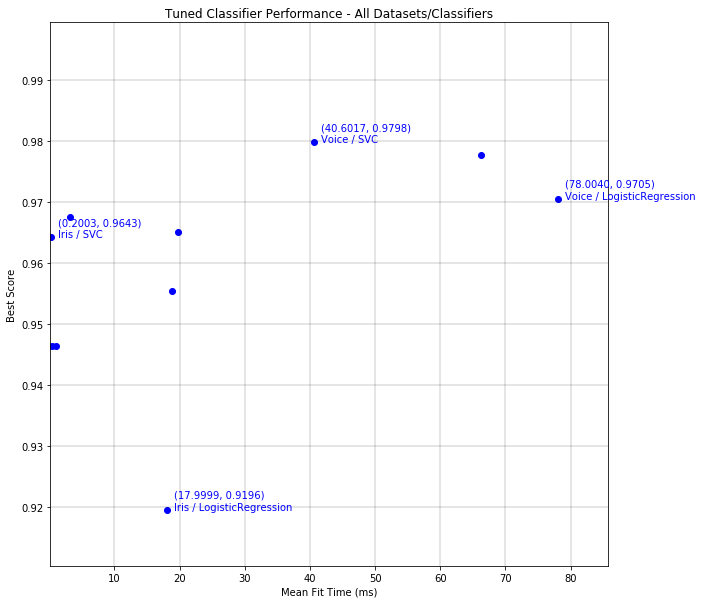

In [55]:
# Plot Classification Performance results: Best Score vs. Mean Fit Time (ms)
fig2 = plt.figure(figsize=(8,8))

# Create a single plot of all results
ax = fig2.add_subplot( 1,1,1 )

# Create the plot
plot_summary(ax, summary_df, False, "Tuned Classifier Performance - All Datasets/Classifiers")

# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning-Combined.png', bbox_inches='tight')

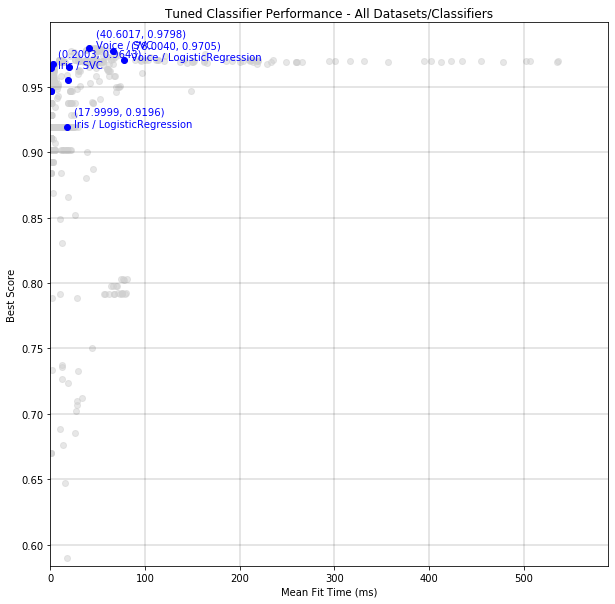

In [58]:
# Plot Classification Performance results: Best Score vs. Mean Fit Time (ms)
fig2 = plt.figure(figsize=(10,10))

# Create a single plot of all results
ax = fig2.add_subplot( 1,1,1 )

# Create the plot
plot_summary(ax, summary_df, True, "Tuned Classifier Performance - All Datasets/Classifiers")

# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning-Including_Suboptimal-Combined.png', bbox_inches='tight')

NOTE: Could not map Dataframe fields to CV Results fields
a_x_col = F1, a_y_col = Best Score


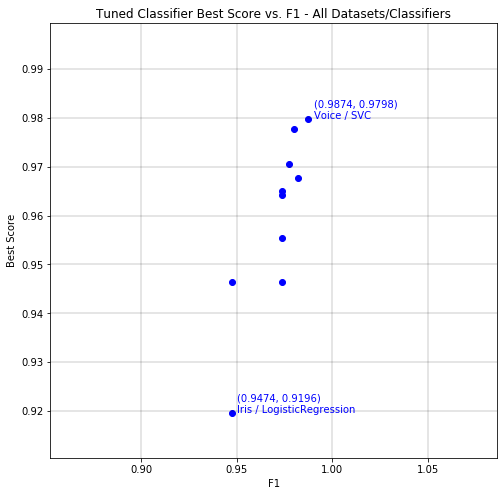

In [50]:
# Plot Classification Performance: Best Score vs. F1 results
fig3 = plt.figure(figsize=(8,8))

# Create a single plot of all results
ax = fig3.add_subplot( 1,1,1 )

# Create the plot
plot_summary(ax, summary_df, True,
             "Tuned Classifier Best Score vs. F1 - All Datasets/Classifiers",
             "F1", "Best Score")

# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning-BestScore_vs_F1-Combined.png', bbox_inches='tight')

NOTE: Could not map Dataframe fields to CV Results fields
a_x_col = Recall, a_y_col = Precision


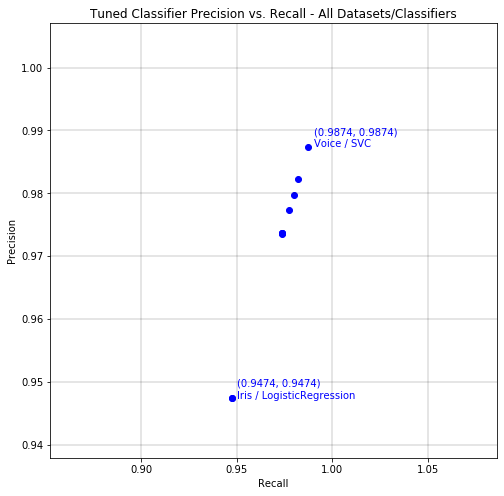

In [51]:
# Plot Classification Performance: Precision vs Recall results
fig3 = plt.figure(figsize=(8,8))

# Create a single plot of all results
ax = fig3.add_subplot( 1,1,1 )

# Create the plot
plot_summary(ax, summary_df, True,
             "Tuned Classifier Precision vs. Recall - All Datasets/Classifiers",
             "Recall", "Precision")

# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning-Precision_vs_Recall-Combined.png', bbox_inches='tight')

## Plot each Dataset/Classifer combination on separate subplot

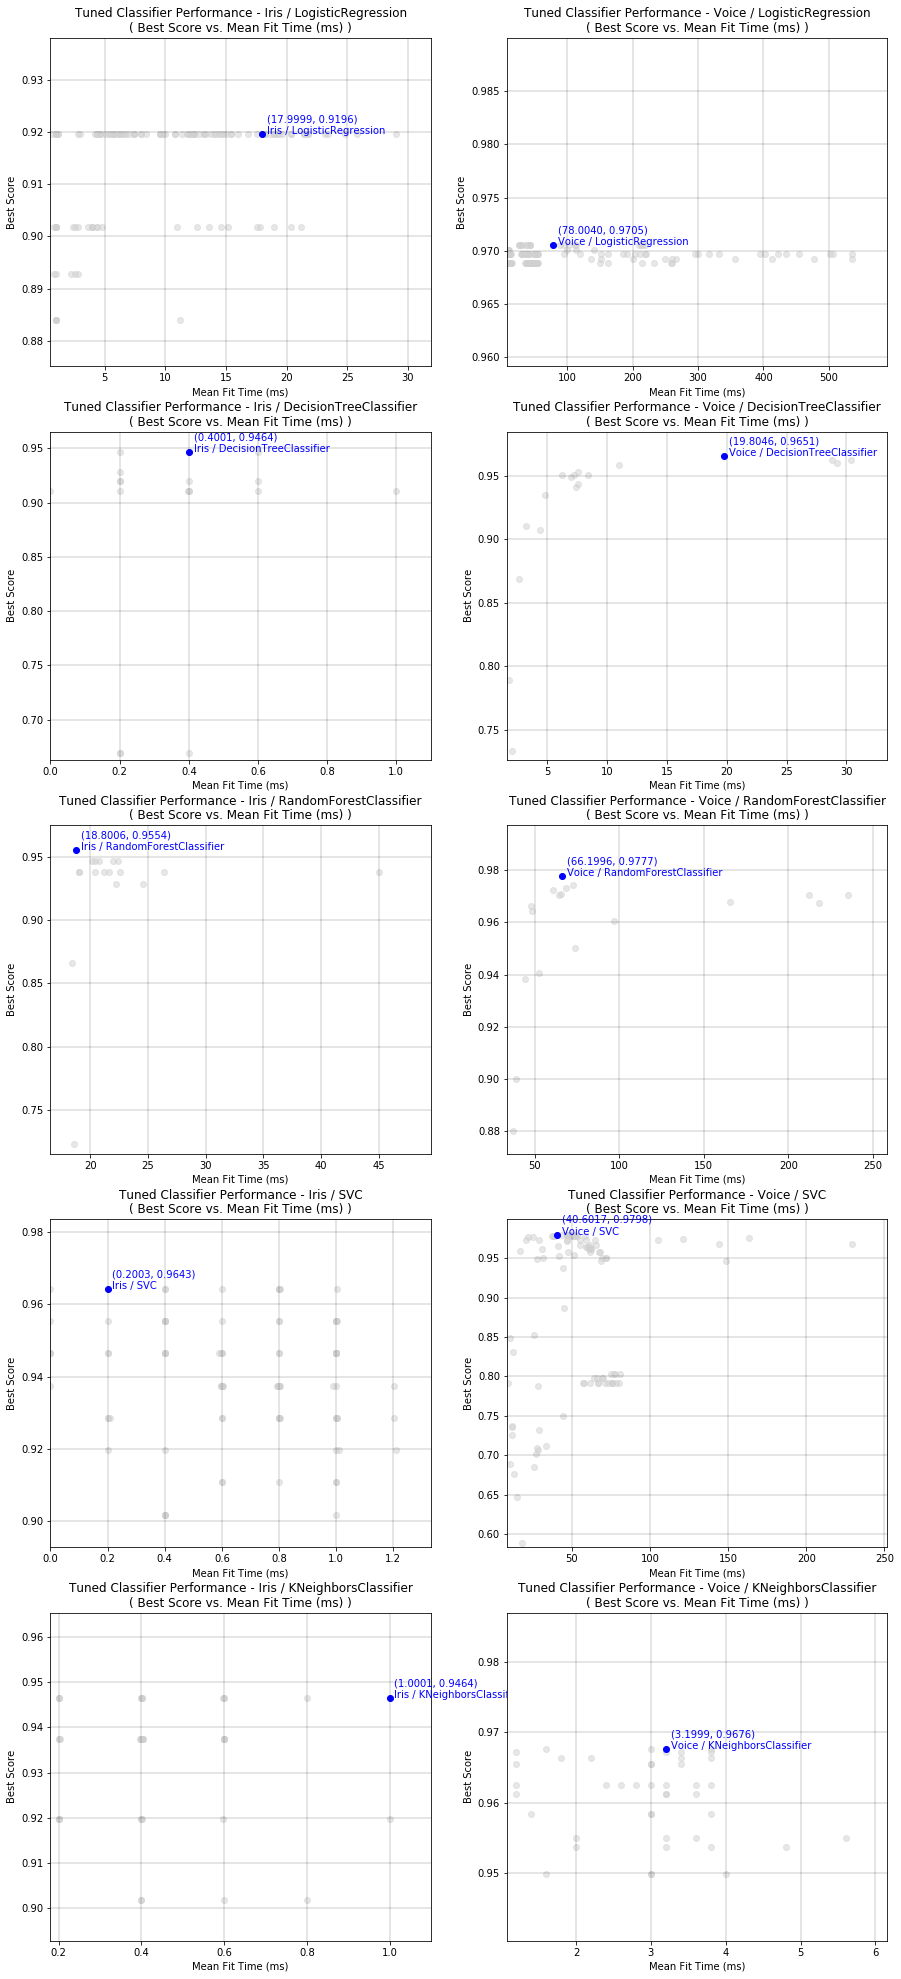

In [52]:
# Plot Classification Performance results
fig1 = plt.figure(figsize=(15,35))

# Create subplots for each Dataset/Classifier combination
ds_list = summary_df['Dataset'].unique()
cls_list = summary_df['Classifier'].unique()

# Create subplots for (# Dataset) columns x (# Classifier) rows
ax_list = []
i_plot = 0
for i_ds in range(len(ds_list)):
    for i_cls in range(len(cls_list)):
        
        # Create the subplot axis and append it to the list of plots
        # Rows: Classifiers, Columns: Datasets
        # Position of a Plot: (Classifier index) * (size of row) + (Dataset index) + 1        
        ax_list.append( fig1.add_subplot(len(cls_list), len(ds_list), i_cls*len(ds_list) + i_ds + 1  ) )

        # Get the relevant subset of the dataframe for this subplot
        target_df = summary_df[ (summary_df['Dataset'] == ds_list[i_ds])
                               & (summary_df['Classifier'] == cls_list[i_cls]) ].reset_index(drop=True)

        # Create the plot
        plot_summary(ax_list[i_plot], target_df, True)

        # Increment the plot counter
        i_plot += 1
        
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning-Subplots.png', bbox_inches='tight')

In [53]:
# Create a dataframe to summarize overall results
table_df = summary_df[['Dataset', 'Classifier', 'Best Score', 'F1', 'Precision', 'Recall',
                       'Mean Fit Time (ms)', 'Std Dev Fit Time (ms)',
                       'Best Parameters']]

# Sort the results by Dataset and descending Best Score results
table_df = table_df.sort_values(
    by=['Dataset', 'Best Score', 'F1', 'Precision', 'Recall', 'Mean Fit Time (ms)', 'Std Dev Fit Time (ms)'],
    ascending=[True, False, False, False, False, True, True], inplace=False).reset_index(drop=True, inplace=False)

# Round the numerical fields
table_df = table_df.round( decimals = {
    'Best Score': 4,'F1': 4, 'Precision': 4, 'Recall': 4, 'Mean Fit Time (ms)': 4, 'Std Dev Fit Time (ms)': 4
})

# Convert the Best Parameters dictionary to a string
table_df['Best Parameters'] = table_df['Best Parameters'].map(lambda x: str(x) )
table_df

,Dataset,Classifier,Best Score,F1,Precision,Recall,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Parameters
0,Iris,SVC,0.9643,0.9737,0.9737,0.9737,0.2003,0.4005,"{'C': 2.0, 'kernel': 'linear', 'max_iter': 100}"
1,Iris,RandomForestClassifier,0.9554,0.9737,0.9737,0.9737,18.8006,2.4828,"{'max_depth': 1, 'max_features': None}"
2,Iris,KNeighborsClassifier,0.9464,0.9737,0.9737,0.9737,1.0001,0.0101,"{'algorithm': 'auto', 'n_neighbors': 5}"
3,Iris,DecisionTreeClassifier,0.9464,0.9474,0.9474,0.9474,0.4001,0.4900,"{'max_depth': None, 'max_features': 'log2'}"
4,Iris,LogisticRegression,0.9196,0.9474,0.9474,0.9474,17.9999,0.6326,"{'C': 2.0, 'max_iter': 100, 'solver': 'newton-..."
5,Voice,SVC,0.9798,0.9874,0.9874,0.9874,40.6017,1.3543,"{'C': 2.0, 'kernel': 'rbf', 'max_iter': 500}"
6,Voice,RandomForestClassifier,0.9777,0.9798,0.9798,0.9798,66.1996,9.7650,"{'max_depth': 8, 'max_features': 'sqrt'}"
7,Voice,LogisticRegression,0.9705,0.9773,0.9773,0.9773,78.0040,4.9391,"{'C': 1.0, 'max_iter': 100, 'solver': 'newton-..."
8,Voice,KNeighborsClassifier,0.9676,0.9823,0.9823,0.9823,3.1999,0.4006,"{'algorithm': 'auto', 'n_neighbors': 1}"
9,Voice,DecisionTreeClassifier,0.9651,0.9735,0.9735,0.9735,19.8046,0.7494,"{'max_depth': 4, 'max_features': None}"


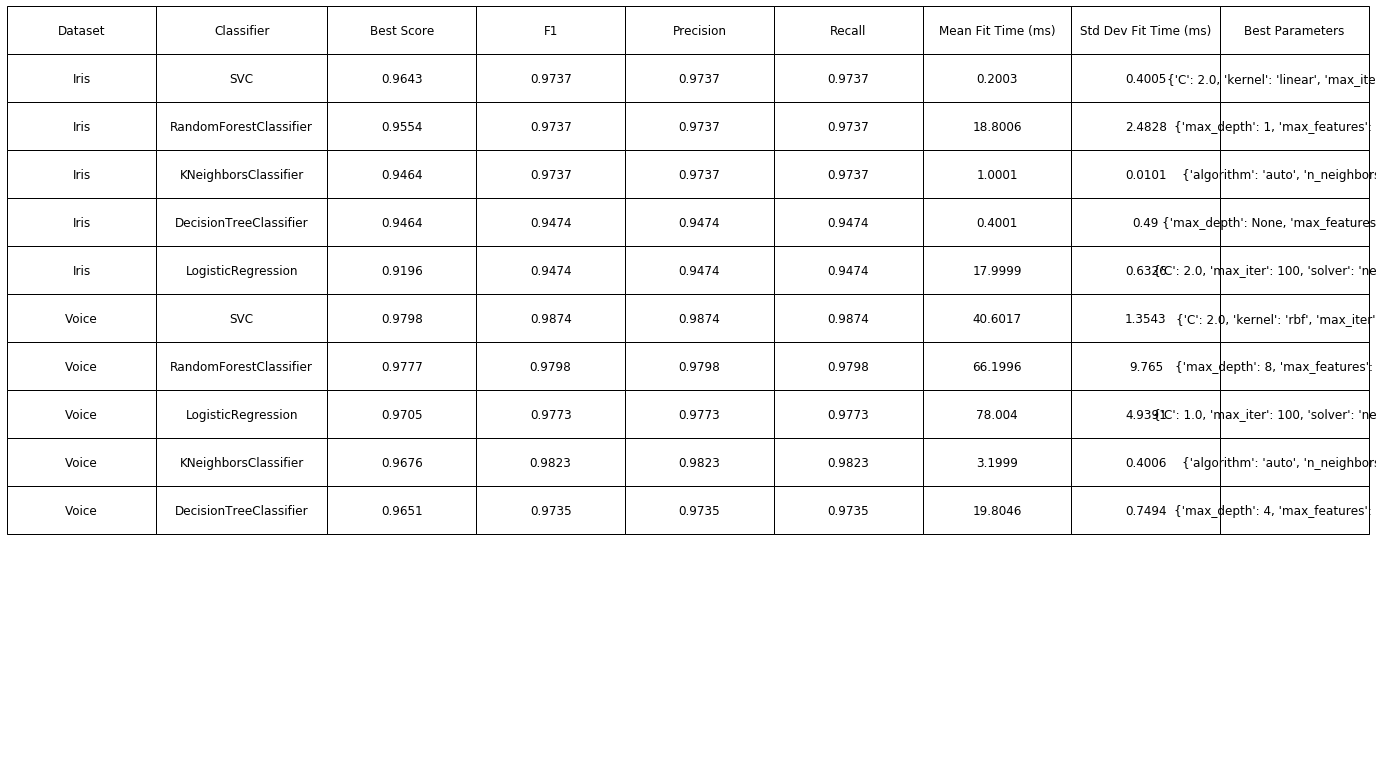

In [54]:
# Table: Performance results
# fig_table_1 = plt.figure(figsize=(15,12))
# fig_table_1 = plt.figure(figsize=(15,10))
fig_table_1 = plt.figure()

# Create axes for this table, but with no visible frame
ax_table = fig_table_1.add_subplot(111, frame_on=False)

# Hide the x and y axes
ax_table.xaxis.set_visible(False)
ax_table.yaxis.set_visible(False)

# Create the table
results_table = plt.table(
            cellText=table_df.values,
#             colWidths = [0.2]*len(table_df.columns),
#             rowLabels=table_df.index,
            colLabels=table_df.columns,
            cellLoc = 'center',
            rowLoc = 'center',
            loc='top')

# Set the fontsize to something readable
results_table.auto_set_font_size(False)
results_table.set_fontsize(12)

# Set the column widths automatically
results_table.auto_set_column_width(True)

# Scale the table
results_table.scale(4,4)

# Show the resulting table
plt.show()
        
# Save the image - use it for Summary of Analysis at the top of the notebook
fig_table_1.savefig('docs/Table-Hyper_Parameter_Tuning.png', bbox_inches='tight') 